__Author: Стурейко Игорь__

__Project: Geekbrains.NeutralNets__

__Lesson 4 - convolutional neural network__

__Date: 2021-12-14__

## Практическое задание

Вариант 1. (простой)

- обучить сверточную нейронную сеть в стиле AlexNet (с падением размера ядра свертки и последовательностью блоков свертка-пулинг  (conv-pool)-(conv-pool)-...) на датасете fashion-mnist или cifar10
- оценить рост точности при увеличении ширины сети (больше ядер)
- оценить рост точности при увеличении глубины сети (больше слоев)
- (опциционально)сравнить с точностью полносвязной сети для этой выборки
    </li>

Вариант 2. (сложный)
- реализовать нейронную сеть или стек из сверток (Concatenate) на сifar10.
- оценить рост точности при увеличении ширины сети (больше ядер), больше нитей.
- оценить рост точности при увеличении глубины сети (больше слоев)
    </li>
</ol>

# Импорты

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Input
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, ZeroPadding2D 
from tensorflow.keras.layers import Dense, Flatten, Concatenate, Activation, Dropout,  BatchNormalization
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import plot_model, to_categorical 
from keras.regularizers import l2

import os

# Загружаем данные

In [ ]:
# разделение тренировочной и тестовой выборки
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'тренировочные примеры')
print(x_test.shape[0], 'тестовые примеры')

# преобразование матрицы чисел 0-9 в бинарную матрицу чисел 0-1
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

170508288/170498071 [==============================] - 16s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 тренировочные примеры
10000 тестовые примеры


# Простой вариант сети AlexNet

Архитектура сети AlexNet содержит восемь слоев с весовыми коэффициентами. Первые пять из них сверточные, а остальные три — полносвязные. Выходные данные пропускаются через функцию потерь softmax, которая формирует распределение меток классов

In [ ]:
def alexnet_model(img_shape=(224, 224, 3), n_classes=10, l2_reg=0.,
	weights=None):

	# Initialize model
	alexnet = Sequential()

	# Layer 1
	alexnet.add(Conv2D(96, (11, 11), input_shape=img_shape,
		padding='same', kernel_regularizer=l2(l2_reg)))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 2
	alexnet.add(Conv2D(256, (5, 5), padding='same'))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 3
	alexnet.add(ZeroPadding2D((1, 1)))
	alexnet.add(Conv2D(512, (3, 3), padding='same'))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 4
	alexnet.add(ZeroPadding2D((1, 1)))
	alexnet.add(Conv2D(1024, (3, 3), padding='same'))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))

	# Layer 5
	alexnet.add(ZeroPadding2D((1, 1)))
	alexnet.add(Conv2D(1024, (3, 3), padding='same'))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 6
	alexnet.add(Flatten())
	alexnet.add(Dense(3072))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(Dropout(0.5))

	# Layer 7
	alexnet.add(Dense(4096))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(Dropout(0.5))

	# Layer 8
	alexnet.add(Dense(n_classes))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('softmax'))

	if weights is not None:
		alexnet.load_weights(weights)

	return alexnet

In [ ]:
model = alexnet_model(img_shape=(32, 32, 3))
# компиляция модели
model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 96)       384       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 32, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 256)      1

### Обучение модели

In [ ]:
# установка параметров нейросети
batch_size = 32
epochs = 10
data_augmentation = False
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

In [ ]:
# аугментация
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False, 
        zca_epsilon=1e-06, 
        rotation_range=5, 
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0., 
        zoom_range=0., 
        channel_shift_range=0.,
        fill_mode='nearest',
        cval=0.,
        horizontal_flip=True,
        vertical_flip=False,
        rescale=None,
        preprocessing_function=None,
        data_format=None,
        validation_split=0.0)

In [ ]:
# запуск data augmentation через fit
model.fit(datagen.flow(x_train, y_train,
                                 batch_size=batch_size),
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    workers=-1)

# сохранение модели и весов
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('сохранить обученную модель как %s ' % model_path)

# проверка работы обученной модели
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Epoch 1/10
1563/1563 [==============================] - 283s 173ms/step - loss: 1.5902 - accuracy: 0.4289 - val_loss: 1.3710 - val_accuracy: 0.5054
Epoch 2/10
1563/1563 [==============================] - 261s 167ms/step - loss: 1.2441 - accuracy: 0.5638 - val_loss: 1.1784 - val_accuracy: 0.5922
Epoch 3/10
1563/1563 [==============================] - 260s 166ms/step - loss: 1.0617 - accuracy: 0.6336 - val_loss: 1.0701 - val_accuracy: 0.6319
Epoch 4/10
1563/1563 [==============================] - 260s 167ms/step - loss: 0.9337 - accuracy: 0.6802 - val_loss: 0.9863 - val_accuracy: 0.6585
Epoch 5/10
1563/1563 [==============================] - 260s 167ms/step - loss: 0.8482 - accuracy: 0.7111 - val_loss: 0.7415 - val_accuracy: 0.7496
Epoch 6/10
1563/1563 [==============================] - 260s 166ms/step - loss: 0.7650 - accuracy: 0.7394 - val_loss: 0.8556 - val_accuracy: 0.7019
Epoch 7/10
1563/1563 [==============================] - 259s 166ms/step - loss: 0.7069 - accuracy: 0.7607 - val_

## Вынесем параметры для удобства экспериментов

In [ ]:
def alex_net(img_shape=(224, 224, 3), n_classes=10, l2_reg = 0., weights=None, n_neutrons=16, n_layers=5):
  alexnet = Sequential()

  for n in np.arange(n_layers):
    alexnet.add(ZeroPadding2D((1, 1)))
    alexnet.add(Conv2D(n_neutrons*2**(n), (n_layers-n, n_layers-n), input_shape=img_shape, 
                       padding='same', kernel_regularizer=l2(l2_reg)))
    alexnet.add(BatchNormalization())
    alexnet.add(Activation('relu'))
    alexnet.add(MaxPooling2D(pool_size=(2, 2)))
  
  # Flatten layer
  alexnet.add(Flatten())

  # First Dense layer
  alexnet.add(Dense(n_neutrons*2**(n_layers-1)))
  alexnet.add(BatchNormalization())
  alexnet.add(Activation('relu'))
  alexnet.add(Dropout(0.5))

  # Second Dense layer width*2
  alexnet.add(Dense(n_neutrons*2**n_layers))
  alexnet.add(BatchNormalization())
  alexnet.add(Activation('relu'))
  alexnet.add(Dropout(0.5))

  # Output layer
  alexnet.add(Dense(n_classes))
  alexnet.add(BatchNormalization())
  alexnet.add(Activation('softmax'))

  if weights is not None:
    alexnet.load_weights(weights)

  return alexnet


In [ ]:
model1 = alex_net(img_shape=(32, 32, 3), n_classes=10, l2_reg=0., weights=None, n_neutrons=16, n_layers=5)
model1.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])
# model1.summary()
model1.fit(datagen.flow(x_train, y_train,
                        batch_size=batch_size),
          epochs=epochs,
          validation_data=(x_test, y_test),
          workers=-1)

Epoch 1/10
1563/1563 [==============================] - 59s 37ms/step - loss: 1.5991 - accuracy: 0.4278 - val_loss: 1.5553 - val_accuracy: 0.4515
Epoch 2/10
1563/1563 [==============================] - 56s 36ms/step - loss: 1.2996 - accuracy: 0.5454 - val_loss: 1.2286 - val_accuracy: 0.5802
Epoch 3/10
1563/1563 [==============================] - 55s 35ms/step - loss: 1.1692 - accuracy: 0.5968 - val_loss: 1.1421 - val_accuracy: 0.5983
Epoch 4/10
1563/1563 [==============================] - 55s 35ms/step - loss: 1.0845 - accuracy: 0.6261 - val_loss: 1.0598 - val_accuracy: 0.6299
Epoch 5/10
1563/1563 [==============================] - 55s 35ms/step - loss: 1.0305 - accuracy: 0.6460 - val_loss: 1.0191 - val_accuracy: 0.6500
Epoch 6/10
1563/1563 [==============================] - 55s 35ms/step - loss: 0.9865 - accuracy: 0.6610 - val_loss: 1.0612 - val_accuracy: 0.6334
Epoch 7/10
1563/1563 [==============================] - 55s 35ms/step - loss: 0.9465 - accuracy: 0.6773 - val_loss: 1.0534 -

In [ ]:
model1.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_33 (ZeroPadd  (None, None, None, None)  0        
 ing2D)                                                          
                                                                 
 conv2d_35 (Conv2D)          (None, None, None, 16)    1216      
                                                                 
 batch_normalization_56 (Bat  (None, None, None, 16)   64        
 chNormalization)                                                
                                                                 
 activation_56 (Activation)  (None, None, None, 16)    0         
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, None, None, 16)   0         
 g2D)                                                            
                                                      

In [ ]:
# проверка работы обученной модели
scores = model1.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

313/313 [==============================] - 2s 7ms/step - loss: 0.7806 - accuracy: 0.7335
Test loss: 0.7806305289268494
Test accuracy: 0.7335000038146973


Уменьшение количества нейронов в слое вдвое привело к сокращению времени обучения в 5 раз (с 260 сек до 55 сек на одну эпоху).

Количество параметров обучения сократилось более чем в 150 раз

Точность сети при этом практически не изменилась.

## Проверка на глубину

In [ ]:
model2 = alex_net(img_shape=(32, 32, 3), n_classes=10, l2_reg=0., weights=None, n_neutrons=8, n_layers=8)
model2.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

In [ ]:
model2.fit(datagen.flow(x_train, y_train,
                        batch_size=batch_size),
          epochs=epochs,
          validation_data=(x_test, y_test),
          workers=-1)

# проверка работы обученной модели
scores = model2.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Epoch 1/10
1563/1563 [==============================] - 80s 49ms/step - loss: 1.6715 - accuracy: 0.3869 - val_loss: 1.6457 - val_accuracy: 0.4132
Epoch 2/10
1563/1563 [==============================] - 81s 52ms/step - loss: 1.4127 - accuracy: 0.4972 - val_loss: 1.6229 - val_accuracy: 0.4312
Epoch 3/10
1563/1563 [==============================] - 84s 54ms/step - loss: 1.2799 - accuracy: 0.5487 - val_loss: 1.3079 - val_accuracy: 0.5408
Epoch 4/10
1563/1563 [==============================] - 84s 54ms/step - loss: 1.1910 - accuracy: 0.5830 - val_loss: 1.1740 - val_accuracy: 0.5936
Epoch 5/10
1563/1563 [==============================] - 84s 54ms/step - loss: 1.1236 - accuracy: 0.6088 - val_loss: 1.1720 - val_accuracy: 0.6080
Epoch 6/10
1563/1563 [==============================] - 84s 54ms/step - loss: 1.0721 - accuracy: 0.6292 - val_loss: 1.3072 - val_accuracy: 0.5554
Epoch 7/10
1563/1563 [==============================] - 83s 53ms/step - loss: 1.0271 - accuracy: 0.6459 - val_loss: 0.9806 -

In [ ]:
model2.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_46 (ZeroPadd  (None, None, None, None)  0        
 ing2D)                                                          
                                                                 
 conv2d_48 (Conv2D)          (None, None, None, 8)     1544      
                                                                 
 batch_normalization_75 (Bat  (None, None, None, 8)    32        
 chNormalization)                                                
                                                                 
 activation_75 (Activation)  (None, None, None, 8)     0         
                                                                 
 max_pooling2d_47 (MaxPoolin  (None, None, None, 8)    0         
 g2D)                                                            
                                                      

Не смотря на то, что количество параметров модели значительно возросло, качество модели прилично просело.

# Для сравнения уберем аугментацию

In [ ]:
model3 = alex_net(img_shape=(32, 32, 3), n_classes=10, l2_reg=0., weights=None, n_neutrons=16, n_layers=5)
model3.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

model3.fit(x_train, y_train,
           batch_size=batch_size,
           epochs=epochs,
           validation_data=(x_test, y_test), 
           shuffle=True)

# проверка работы обученной модели
scores = model3.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Epoch 1/10
1563/1563 [==============================] - 25s 15ms/step - loss: 1.5374 - accuracy: 0.4542 - val_loss: 1.3884 - val_accuracy: 0.5115
Epoch 2/10
1563/1563 [==============================] - 22s 14ms/step - loss: 1.1832 - accuracy: 0.5920 - val_loss: 1.2819 - val_accuracy: 0.5392
Epoch 3/10
1563/1563 [==============================] - 23s 15ms/step - loss: 1.0170 - accuracy: 0.6531 - val_loss: 1.2086 - val_accuracy: 0.5832
Epoch 4/10
1563/1563 [==============================] - 24s 15ms/step - loss: 0.9244 - accuracy: 0.6879 - val_loss: 1.1734 - val_accuracy: 0.6083
Epoch 5/10
1563/1563 [==============================] - 22s 14ms/step - loss: 0.8533 - accuracy: 0.7144 - val_loss: 1.2119 - val_accuracy: 0.6092
Epoch 6/10
1563/1563 [==============================] - 22s 14ms/step - loss: 0.7836 - accuracy: 0.7364 - val_loss: 0.8598 - val_accuracy: 0.7058
Epoch 7/10
1563/1563 [==============================] - 22s 14ms/step - loss: 0.7379 - accuracy: 0.7525 - val_loss: 0.8038 -

Особой разницы в точности не замечено, время затраченное на аугментацию не оправдалось (что странно - должна помогать в обучении). Возможно надо дольше учить модель.

# Соберем цепочку с конкатенацией

In [ ]:
def diff_model(img_shape=(224, 224, 3), n_classes=10, l2_reg=0.,
	weights=None):

	
  first_input = Input(shape=img_shape)

  x11 = Conv2D(48, 5, activation='relu', padding = 'same')(first_input)
  x12 = MaxPooling2D(pool_size=(2, 2))(x11)
  
  
  
  x21= Conv2D(16, 5, activation='relu', padding = 'same')(first_input)
  x22 = MaxPooling2D(pool_size=(2, 2))(x21)
  
  merge_one = Concatenate(   )([x12, x22])
  
  x31 = Conv2D(10, 1, activation='relu', padding = 'same')(first_input)
  x32 = MaxPooling2D(pool_size=(2, 2))(x31)

  merge_two = Concatenate( axis=-1)([merge_one, x32])

  out = Dense(10, activation='softmax')(merge_two)
   
  model_stek = Model(inputs=first_input, outputs=out)
  return model_stek

In [ ]:
ada_grad = tf.keras.optimizers.Adagrad(learning_rate=0.1, epsilon=1e-08, decay=0.0)
  
model4 = diff_model(img_shape=(32, 32, 3))

model4.compile(optimizer=ada_grad, loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

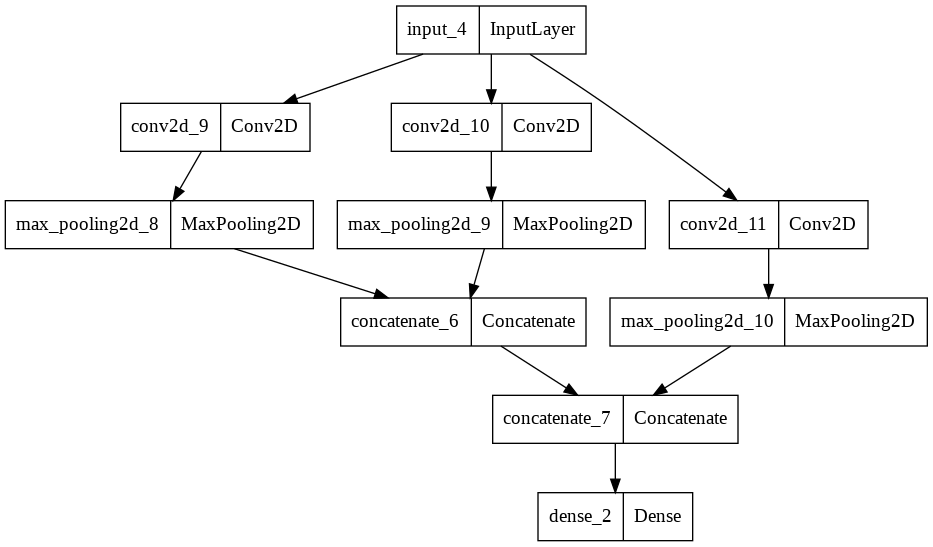

In [ ]:
plot_model(model4,'model4.png')

In [ ]:
model4.fit(x_train, y_train,
           batch_size=batch_size,
           epochs=epochs,
           validation_data=(x_test, y_test), 
           shuffle=True)

# проверка работы обученной модели
scores = model4.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Epoch 1/10


ValueError: ignored

## Не смог понять в чем собственно ошибка. Где-то не сошлись размерности, но вот где?!...

### Буду благодарен за подсказку :)

# Для сравнения посмотрим результаты на структуре ResNet50
Идея реализации позаимствована с https://github.com/raghakot/keras-resnet.git

Дополнения мои - по обновлениям струтуры библиотек

In [ ]:
from __future__ import division

import six
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Activation,
    Dense,
    Flatten
)
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    AveragePooling2D
)
from tensorflow.keras.layers import add
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K


def _bn_relu(input):
    """Helper to build a BN -> relu block
    """
    norm = BatchNormalization(axis=CHANNEL_AXIS)(input)
    return Activation("relu")(norm)


def _conv_bn_relu(**conv_params):
    """Helper to build a conv -> BN -> relu block
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        conv = Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(input)
        return _bn_relu(conv)

    return f


def _bn_relu_conv(**conv_params):
    """Helper to build a BN -> relu -> conv block.
    This is an improved scheme proposed in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        activation = _bn_relu(input)
        return Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(activation)

    return f


def _shortcut(input, residual):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = K.int_shape(input)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]

    shortcut = input
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        shortcut = Conv2D(filters=residual_shape[CHANNEL_AXIS],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input)

    return add([shortcut, residual])


def _residual_block(block_function, filters, repetitions, is_first_layer=False):
    """Builds a residual block with repeating bottleneck blocks.
    """
    def f(input):
        for i in range(repetitions):
            init_strides = (1, 1)
            if i == 0 and not is_first_layer:
                init_strides = (2, 2)
            input = block_function(filters=filters, init_strides=init_strides,
                                   is_first_block_of_first_layer=(is_first_layer and i == 0))(input)
        return input

    return f


def basic_block(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Basic 3 X 3 convolution blocks for use on resnets with layers <= 34.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv1 = Conv2D(filters=filters, kernel_size=(3, 3),
                           strides=init_strides,
                           padding="same",
                           kernel_initializer="he_normal",
                           kernel_regularizer=l2(1e-4))(input)
        else:
            conv1 = _bn_relu_conv(filters=filters, kernel_size=(3, 3),
                                  strides=init_strides)(input)

        residual = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv1)
        return _shortcut(input, residual)

    return f


def bottleneck(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Bottleneck architecture for > 34 layer resnet.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf

    Returns:
        A final conv layer of filters * 4
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv_1_1 = Conv2D(filters=filters, kernel_size=(1, 1),
                              strides=init_strides,
                              padding="same",
                              kernel_initializer="he_normal",
                              kernel_regularizer=l2(1e-4))(input)
        else:
            conv_1_1 = _bn_relu_conv(filters=filters, kernel_size=(1, 1),
                                     strides=init_strides)(input)

        conv_3_3 = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv_1_1)
        residual = _bn_relu_conv(filters=filters * 4, kernel_size=(1, 1))(conv_3_3)
        return _shortcut(input, residual)

    return f


def _handle_dim_ordering():
    global ROW_AXIS
    global COL_AXIS
    global CHANNEL_AXIS
    if K.image_data_format() == 'channels_last':
        ROW_AXIS = 1
        COL_AXIS = 2
        CHANNEL_AXIS = 3
    else:
        CHANNEL_AXIS = 1
        ROW_AXIS = 2
        COL_AXIS = 3


def _get_block(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier


class ResnetBuilder(object):
    @staticmethod
    def build(input_shape, num_outputs, block_fn, repetitions):
        """Builds a custom ResNet like architecture.

        Args:
            input_shape: The input shape in the form (nb_channels, nb_rows, nb_cols)
            num_outputs: The number of outputs at final softmax layer
            block_fn: The block function to use. This is either `basic_block` or `bottleneck`.
                The original paper used basic_block for layers < 50
            repetitions: Number of repetitions of various block units.
                At each block unit, the number of filters are doubled and the input size is halved

        Returns:
            The keras `Model`.
        """
        _handle_dim_ordering()
        if len(input_shape) != 3:
            raise Exception("Input shape should be a tuple (nb_channels, nb_rows, nb_cols)")

        # Permute dimension order if necessary
        if K.image_data_format() == 'channels_last':
            input_shape = (input_shape[1], input_shape[2], input_shape[0])

        # Load function from str if needed.
        block_fn = _get_block(block_fn)

        input = Input(shape=input_shape)
        conv1 = _conv_bn_relu(filters=64, kernel_size=(7, 7), strides=(2, 2))(input)
        pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(conv1)

        block = pool1
        filters = 64
        for i, r in enumerate(repetitions):
            block = _residual_block(block_fn, filters=filters, repetitions=r, is_first_layer=(i == 0))(block)
            filters *= 2

        # Last activation
        block = _bn_relu(block)

        # Classifier block
        block_shape = K.int_shape(block)
        pool2 = AveragePooling2D(pool_size=(block_shape[ROW_AXIS], block_shape[COL_AXIS]),
                                 strides=(1, 1))(block)
        flatten1 = Flatten()(pool2)
        dense = Dense(units=num_outputs, kernel_initializer="he_normal",
                      activation="softmax")(flatten1)

        model = Model(inputs=input, outputs=dense)
        return model

    @staticmethod
    def build_resnet_18(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [2, 2, 2, 2])

    @staticmethod
    def build_resnet_34(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_50(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_101(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 23, 3])

    @staticmethod
    def build_resnet_152(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 8, 36, 3])

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
early_stopper = EarlyStopping(min_delta=0.001, patience=10)
csv_logger = CSVLogger('resnet18_cifar10.csv')

batch_size = 32
nb_classes = 10
nb_epoch = 20
data_augmentation = True

# input image dimensions
img_rows, img_cols = 32, 32
# The CIFAR10 images are RGB.
img_channels = 3

# The data, shuffled and split between train and test sets:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Convert class vectors to binary class matrices.
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# subtract mean and normalize
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_test -= mean_image
X_train /= 128.
X_test /= 128.

model = ResnetBuilder.build_resnet_50((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(X_train, Y_train,
              batch_size=batch_size,
              nb_epoch=nb_epoch,
              validation_data=(X_test, Y_test),
              shuffle=True,
              callbacks=[lr_reducer, early_stopper, csv_logger])
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(X_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                        steps_per_epoch=X_train.shape[0] // batch_size,
                        validation_data=(X_test, Y_test),
                        epochs=nb_epoch, verbose=1, max_queue_size=100,
                        callbacks=[lr_reducer, early_stopper, csv_logger])

Using real-time data augmentation.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/20
1562/1562 [==============================] - 208s 127ms/step - loss: 3.8366 - accuracy: 0.4377 - val_loss: 2.4381 - val_accuracy: 0.4989 - lr: 0.0010
Epoch 2/20
1562/1562 [==============================] - 180s 115ms/step - loss: 2.1038 - accuracy: 0.5298 - val_loss: 12.9376 - val_accuracy: 0.3886 - lr: 0.0010
Epoch 3/20
1562/1562 [==============================] - 178s 114ms/step - loss: 1.7783 - accuracy: 0.5702 - val_loss: 1.6493 - val_accuracy: 0.6086 - lr: 0.0010
Epoch 4/20
1562/1562 [==============================] - 180s 115ms/step - loss: 1.5947 - accuracy: 0.6082 - val_loss: 1.5820 - val_accuracy: 0.6073 - lr: 0.0010
Epoch 5/20
1562/1562 [==============================] - 181s 116ms/step - loss: 1.4700 - accuracy: 0.6407 - val_loss: 1.5065 - val_accuracy: 0.6299 - lr: 0.0010
Epoch 6/20
1562/1562 [==============================] - 179s 115ms/step - loss: 1.3541 - accuracy: 0.6636 - val_loss: 1.2622 - val_accuracy: 0.6921 - lr: 0.0010
Epoch 7/20
1562/1562 [===========

In [ ]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_118 (Conv2D)            (None, 16, 16, 64)   9472        ['input_7[0][0]']                
                                                                                                  
 batch_normalization_98 (BatchN  (None, 16, 16, 64)  256         ['conv2d_118[0][0]']             
 ormalization)                                                                                    
                                                                                                  
 activation_98 (Activation)     (None, 16, 16, 64)   0           ['batch_normalization_98[0]

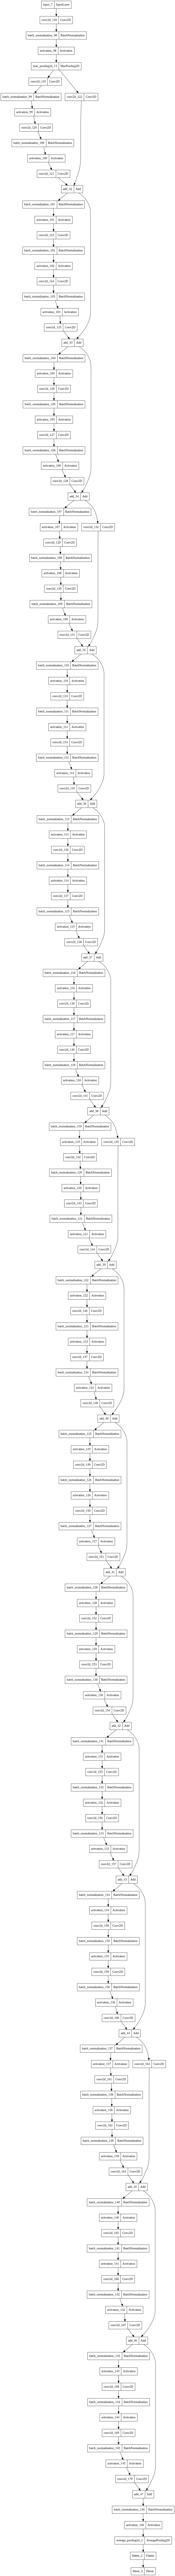

In [ ]:
plot_model(model,'ResNet50.png')

In [ ]:
# проверка работы обученной модели
scores = model.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

313/313 [==============================] - 12s 37ms/step - loss: 1.0206 - accuracy: 0.7548
Test loss: 1.020593523979187
Test accuracy: 0.754800021648407


## Особой разницы в точности не заметил. Возможно 20 эпох мало - нужно больше. 

В описании модели ResNet рекомендуют не менее 200 эпох обучения, но столько времени ждать у меня не получается.